![Py4Eng](img/logo.png)

# Image processing
## Yoav Ram

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, misc
from skimage import filters
from skimage.morphology import square

def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])

# Denoising

Here's a salt-and-pepper noisy image of a famous person:

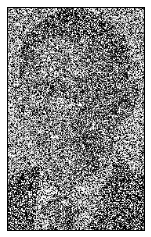

In [2]:
noisy = np.loadtxt(r'../data/noisy.bitmap')
display_image(noisy)

[![SciPy logo](http://space-kerala.org/freeelectron/wp-content/uploads/2013/11/scipyshiny_small.png)](http://scipy.org)

First let's try to denoise it with Scipy's median filter:

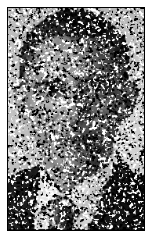

In [3]:
denoised = signal.medfilt2d(noisy)
display_image(denoised)

[![scikit-image](http://scikit-image.org/docs/stable/_static/img/logo.png)](http://scikit-image.org/)

Now using Scikit-image:

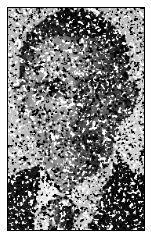

In [5]:
display_image(filters.median(noisy.astype(np.uint16), square(3)))

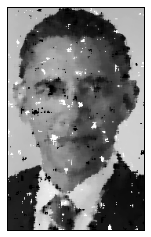

In [6]:
display_image(filters.median(noisy.astype(np.uint16), square(7)))

## Bounded median

Now let's apply our own bounded median filter.

We want to replace the value of each outlier (noisy) pixel with the median of non-outlier neighbors. We'll write to functions, one to do it for white pixels and one for black pixels:

In [7]:
def fix_white(arr, white_th):
    center = arr.size // 2
    if arr[center] > white_th:
        bounded = arr[arr <= white_th]
        if bounded.size:
            return np.median(bounded)
    # either center was not extreme or all its neighbors are extreme
    return arr[center]

def fix_black(arr, black_th):
    center = arr.size // 2
    if arr[center] < black_th:
        bounded = arr[arr >= black_th]
        if bounded.size:
            return np.median(bounded)
    # either center was not extreme or all its neighbors are extreme
    return arr[center]  

To apply these functions to each pixel we use SciPy's `generic_filter`, which accepts an image, a neighborhood definition, and a function to apply on the neighborhood to determine the pixel value.

In [8]:
from scipy.ndimage import generic_filter
generic_filter?

In [9]:
def bounded_median(image, k=1, black_th=10, white_th=250):
    n = 2 * k + 1
    res = generic_filter(image, fix_white, size=(n, n), extra_keywords={'white_th': white_th})
    res = generic_filter(res, fix_black, size=(n, n), extra_keywords={'black_th': black_th})
    return res

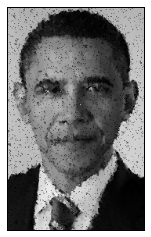

In [10]:
denoised = bounded_median(noisy)
display_image(denoised)

That's much better!

## Exercise

Use `generic_filter` to apply a **dilation** filter on the following horse image: replace each pixel with the maximum of it's neighborhood.

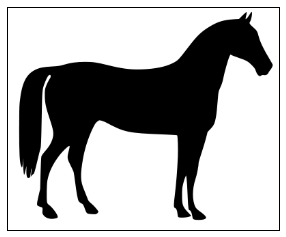

In [11]:
import skimage.data
horse = skimage.data.horse()[:,:,0]
display_image(horse)

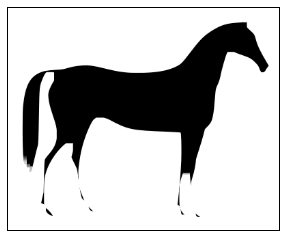

In [12]:

display_image(dilated)

## Adding salt and pepper noise

Here's how the noise was added in the first place:

In [13]:
def salt_pepper(image, p=0.01):
    """Generates salt and pepper noise.
    
    Each pixel is "hit" independently with probability `p`. 
    If hit, a pixel has 1:1 chance of becoming white or black.
    """
    noisy = image.copy()
    rand = np.random.random(size=noisy.shape)
    idx = rand <= p/2
    noisy[idx] = 0
    idx = (p/2 < rand) & (rand <= p)
    noisy[idx] = 255
    return noisy

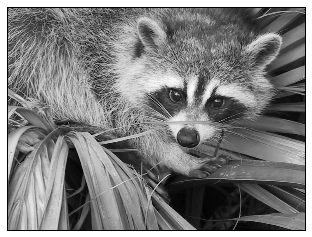

In [14]:
image = misc.face(gray=True)
display_image(image)

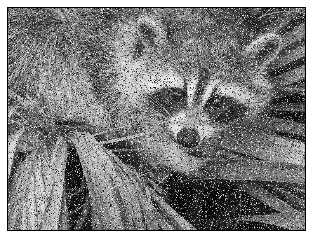

In [15]:
display_image(salt_pepper(image, p=0.2))

# Gaussian filter

Let's apply a gaussian filter for blurring. We'll use this image:

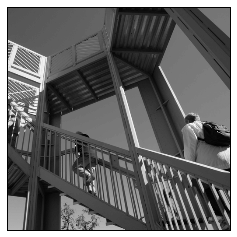

In [6]:
image = misc.ascent()
display_image(image)

## scipy.signal

We define a gaussian window using `scipy.signal.gaussian` of width 50 and $\sigma=10$:

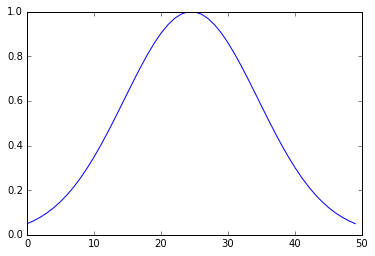

In [19]:
window = signal.gaussian(50, 10)
plt.plot(window);

Because the 2D gaussian filter can be described by the product of two 1D functions, we can use the function `scipy.signal.sepfir2d` to apply the filter:

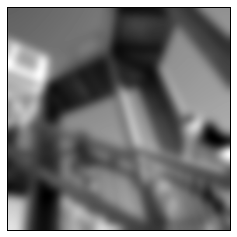

In [20]:
blurred = signal.sepfir2d(image, window, window)
display_image(blurred)

## scikit-image

Scikit-image has a function to apply a  gaussian filter, so let's just use it:

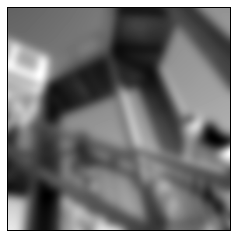

In [21]:
blurred = filters.gaussian_filter(image, sigma=10)
display_image(blurred)

## Exercise

Use one of scikit-image's filters to find edge magnitude in the ascent image (last used image). Plot the result. 

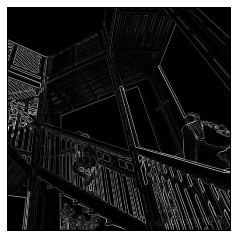

# Labeling with `scipy.ndimage`

Now we will find objects in an image, and measure their sizes.

We'll work with the greek coins image from the scikit-image package.

Shape (303, 384)


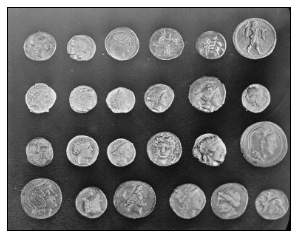

In [211]:
import scipy.ndimage
import skimage.measure
import skimage.data

img = skimage.data.coins()
print("Shape", img.shape)
display_image(img)

First, we do a binary segmentation. Here I use a static threshold, but we could use something more clever from `skimage.filters` like `threshold_otsu` but in this case it works better to set the threshold to 120:

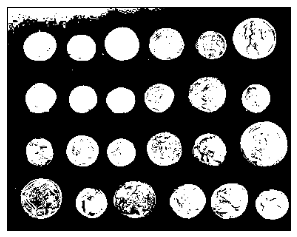

In [202]:
th = 120
bw = (img > th)
display_image(bw)

Next we use a dilation operator to (our own from before!) to clean up the coins.

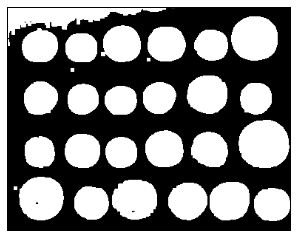

In [205]:
dilated = generic_filter(bw, max, size=(5, 5))
display_image(dilated)

Now we do the labeling using `scipy.ndimage.label`:

In [206]:
labels, n_labels = scipy.ndimage.label(dilated!=0)
n

37

The `labels` array specifies the label of each pixel, so we can plot it using a qualitative colormap to view the labels:

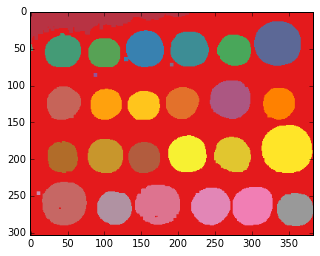

In [209]:
plt.imshow(labels, cmap=plt.cm.Set1);

We can use `skimage.measure.regionprops` to measure the properties of the labeled coins, such as their centroid, for adding a text label to the plot, and the area, to filter out small labels:

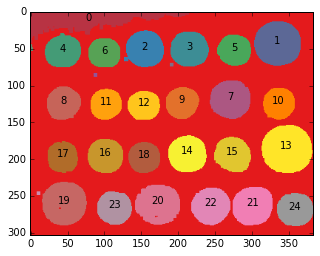

In [213]:
label_props = skimage.measure.regionprops(labels)
label_props = [props for props in label_props if props.area > 500]
plt.imshow(labels, cmap=plt.cm.Set1)
for i, props in enumerate(label_props):
    y, x = props.centroid
    plt.text(x, y, i, fontdict={'horizontalalignment':'center'})

Or we can plot a histogram of the areas:

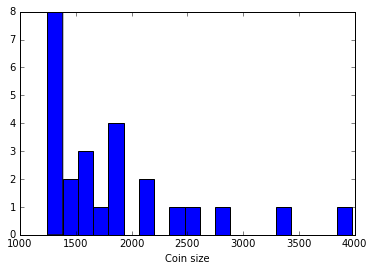

In [178]:
areas = [props.area for props in label_props]
plt.hist(areas, bins=20)
plt.xlabel('Coin size');

# References

- [Scipy.Signal tutorial](https://scipy.github.io/devdocs/tutorial/signal.html)
- [Scipy.ndimage docs](https://docs.scipy.org/doc/scipy/reference/ndimage.html)
- [Scipy.ndimage tutorial](https://docs.scipy.org/doc/scipy-0.17.0/reference/tutorial/ndimage.html)
- [Scikit-Image docs](http://scikit-image.org/docs/0.11.x/)

## Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the _Python for Engineers_ course.

The notebook was written using [Python](http://pytho.org/) 3.4.4, [IPython](http://ipython.org/) 4.0.3 and [Jupyter](http://jupyter.org) 4.0.6.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)